In [3]:
# Лабораторна робота: Реалізація та Аналіз Дерев Рішень для Класифікації
# Датасет: Global Coffee Health Dataset

# ============================================================================
# ЧАСТИНА 0: Імпорт бібліотек та завантаження даних
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                             matthews_corrcoef, classification_report)
from sklearn.inspection import permutation_importance
import time
import warnings
warnings.filterwarnings('ignore')

# Налаштування для графіків
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("📊 Завантаження датасету...")

df = pd.read_csv('synthetic_coffee_health_10000.csv')

print(f"Розмір датасету: {df.shape}")
print(f"\nПерші рядки:")
print(df.head())
print(f"\nІнформація про датасет:")
print(df.info())
print(f"\nСтатистика:")
print(df.describe())

📊 Завантаження датасету...
Розмір датасету: (10000, 16)

Перші рядки:
   ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1   40    Male  Germany            3.5        328.1          7.5   
1   2   33    Male  Germany            1.0         94.1          6.2   
2   3   42    Male   Brazil            5.3        503.7          5.9   
3   4   53    Male  Germany            2.6        249.2          7.3   
4   5   32  Female    Spain            3.1        298.0          5.3   

  Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
0          Good  24.9          78          Low                     14.5   
1          Good  20.0          67          Low                     11.0   
2          Fair  22.7          59       Medium                     11.2   
3          Good  24.7          71          Low                      6.6   
4          Fair  24.1          76       Medium                      8.5   

  Health_Issues Occupation  Smoking  Alcohol_C


ЧАСТИНА A: Власна реалізація дерева рішень

🔧 Обробка датасету...
Ознаки: ['Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Occupation', 'Smoking', 'Alcohol_Consumption']
Розподіл класів:
Health_Issues
Mild        3579
Moderate     463
Severe        17
Name: count, dtype: int64

Класи: ['Mild' 'Moderate' 'Severe' nan]

Оброблені ознаки: ['Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Occupation', 'Smoking', 'Alcohol_Consumption']

Розміри вибірок:
Train: (6400, 14), Validation: (1600, 14), Test: (2000, 14)

🌳 Навчання власного дерева рішень...
Час навчання: 3.9330 сек

📊 Результати власного дерева:
Train Accuracy: 0.9998
Test Accuracy: 0.9940
Test F1-score (macro): 0.9865
Test MCC: 0.9884

Confusion Matrix:
[[ 711    2    0    3]
 [   6   87    0    0]
 [   0    0    3  

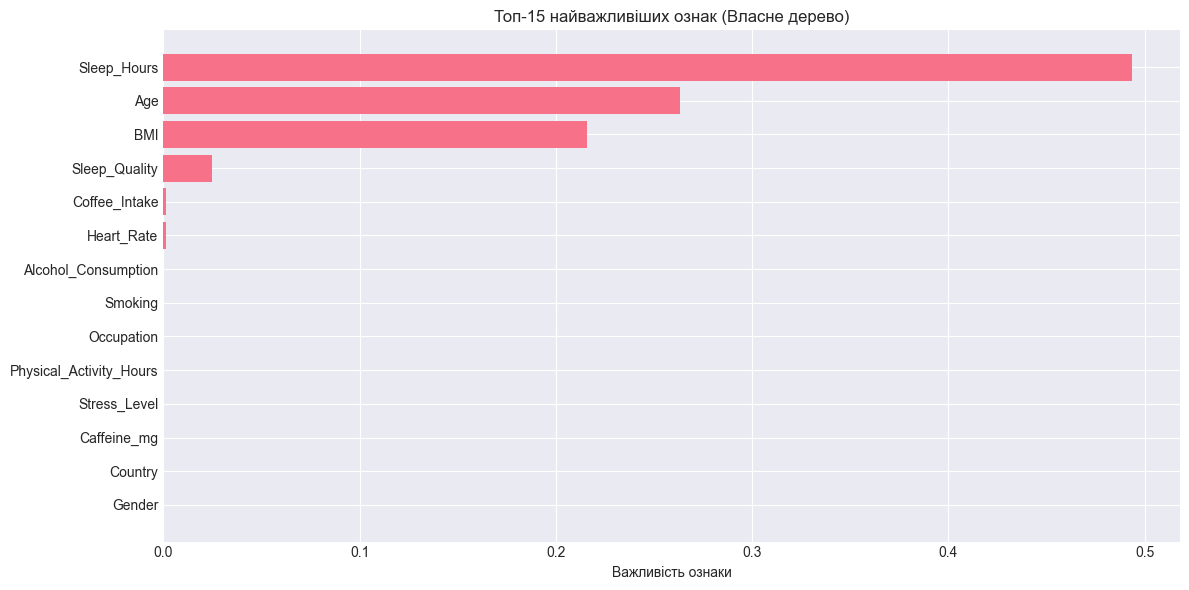

In [7]:
# ============================================================================
# ЧАСТИНА A: Реалізація Власного Дерева Рішень з Gini Index
# ============================================================================

class MyDecisionTree:
    """
    Власна реалізація дерева рішень з критерієм Gini та обчисленням важливості ознак
    """
    
    def __init__(self, max_depth=5, min_samples=2):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.feature_importance = None
        self.tree = None
        self.n_features = None
        self.n_classes = None
        self.classes = None
        
    def gini(self, y):
        """
        Обчислює Gini impurity для масиву міток класів
        Gini = 1 - Σ(p_i^2), де p_i - частка класу i
        """
        if len(y) == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def best_split(self, X, y):
        """
        Знаходить найкращий розділ для даних
        Повертає: ознаку, поріг та weighted Gini після розділу
        """
        best_gini = float('inf')
        best_feature = None
        best_threshold = None
        n_samples = len(y)
        
        for feature in range(X.shape[1]):
            # Отримуємо унікальні значення для ознаки
            thresholds = np.unique(X[:, feature])
            
            # Пробуємо кожне можливе значення як поріг
            for threshold in thresholds:
                # Розділяємо дані
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                # Обчислюємо зважену Gini
                left_gini = self.gini(y[left_mask])
                right_gini = self.gini(y[right_mask])
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                
                weighted_gini = (n_left / n_samples) * left_gini + (n_right / n_samples) * right_gini
                
                # Оновлюємо найкращий розділ
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gini
    
    def build_tree(self, X, y, depth=0):
        """
        Рекурсивно будує дерево рішень
        """
        n_samples = len(y)
        n_classes = len(np.unique(y))
        
        # Умови зупинки
        if (depth >= self.max_depth or 
            n_samples < self.min_samples or 
            n_classes == 1):
            # Створюємо листовий вузол
            leaf_value = np.argmax(np.bincount(y.astype(int)))
            return {
                'leaf': True,
                'class': leaf_value,
                'n_samples': n_samples,
                'gini': self.gini(y)
            }
        
        # Знаходимо найкращий розділ
        feature, threshold, weighted_gini = self.best_split(X, y)
        
        if feature is None:
            # Не знайдено хорошого розділу
            leaf_value = np.argmax(np.bincount(y.astype(int)))
            return {
                'leaf': True,
                'class': leaf_value,
                'n_samples': n_samples,
                'gini': self.gini(y)
            }
        
        # Обчислюємо важливість ознаки для цього вузла
        node_gini = self.gini(y)
        importance = (n_samples / self.n_total) * (node_gini - weighted_gini)
        self.feature_importance[feature] += importance
        
        # Розділяємо дані
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        
        # Рекурсивно будуємо піддерева
        left_subtree = self.build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self.build_tree(X[right_mask], y[right_mask], depth + 1)
        
        # Повертаємо вузол рішення
        majority_class = np.argmax(np.bincount(y.astype(int)))
        return {
            'leaf': False,
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree,
            'n_samples': n_samples,
            'gini': node_gini,
            'class': majority_class
        }
    
    def fit(self, X, y):
        """
        Навчає дерево та обчислює нормалізовану важливість ознак
        """
        self.n_total = len(y)
        self.n_features = X.shape[1]
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.feature_importance = np.zeros(X.shape[1])
        
        # Будуємо дерево
        self.tree = self.build_tree(X, y)
        
        # Нормалізуємо важливість
        if np.sum(self.feature_importance) > 0:
            self.feature_importance /= np.sum(self.feature_importance)
        
        return self
    
    def predict_one(self, x, node):
        """
        Прогнозує клас для одного зразка
        """
        if node['leaf']:
            return node['class']
        
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])
    
    def predict(self, X):
        """
        Прогнозує класи для всіх зразків
        """
        return np.array([self.predict_one(x, self.tree) for x in X])
    
    def count_leaves(self, node):
        """
        Підраховує кількість листів у піддереві
        """
        if node['leaf']:
            return 1
        return self.count_leaves(node['left']) + self.count_leaves(node['right'])
    
    def calculate_error(self, X, y, node):
        """
        Обчислює помилку класифікації для вузла
        """
        predictions = self.predict(X)
        return np.sum(predictions != y)
    
    def prune_tree(self, node, alpha, validation_X, validation_y):
        """
        Виконує cost-complexity pruning
        """
        if node['leaf']:
            return self.calculate_error(validation_X, validation_y, node)
        
        # Рекурсивно обробляємо піддерева
        left_error = self.prune_tree(node['left'], alpha, validation_X, validation_y)
        right_error = self.prune_tree(node['right'], alpha, validation_X, validation_y)
        
        subtree_error = left_error + right_error
        subtree_complexity = alpha * self.count_leaves(node)
        
        # Обчислюємо помилку якщо зробити цей вузол листом
        temp_node = {'leaf': True, 'class': node['class']}
        leaf_error = self.calculate_error(validation_X, validation_y, temp_node)
        leaf_complexity = alpha
        
        # Вирішуємо чи робити прунінг
        if leaf_error + leaf_complexity <= subtree_error + subtree_complexity:
            node['leaf'] = True
            if 'left' in node:
                del node['left']
            if 'right' in node:
                del node['right']
            if 'feature' in node:
                del node['feature']
            if 'threshold' in node:
                del node['threshold']
            return leaf_error
        
        return subtree_error

print("\n" + "="*80)
print("ЧАСТИНА A: Власна реалізація дерева рішень")
print("="*80)

# ============================================================================
# ОБРОБКА ДАНИХ
# ============================================================================

print("\n🔧 Обробка датасету...")

# Видаляємо ID
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)

# Розділяємо на ознаки та цільову змінну
X = df.drop('Health_Issues', axis=1)
y = df['Health_Issues']

print(f"Ознаки: {X.columns.tolist()}")
print(f"Розподіл класів:\n{y.value_counts()}")

# Кодуємо цільову змінну
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"\nКласи: {le_target.classes_}")

# Кодуємо категоріальні ознаки
categorical_cols = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
                   'Occupation', 'Smoking', 'Alcohol_Consumption']

label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col])
        label_encoders[col] = le

print(f"\nОброблені ознаки: {X_encoded.columns.tolist()}")

# Розділяємо на train/validation/test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"\nРозміри вибірок:")
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

# ============================================================================
# НАВЧАННЯ ВЛАСНОГО ДЕРЕВА
# ============================================================================

print("\n🌳 Навчання власного дерева рішень...")
start_time = time.time()

my_tree = MyDecisionTree(max_depth=10, min_samples=5)
my_tree.fit(X_train.values, y_train)

training_time = time.time() - start_time
print(f"Час навчання: {training_time:.4f} сек")

# Прогнозування
y_pred_train = my_tree.predict(X_train.values)
y_pred_test = my_tree.predict(X_test.values)

# Метрики
print(f"\n📊 Результати власного дерева:")
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Test F1-score (macro): {f1_score(y_test, y_pred_test, average='macro'):.4f}")
print(f"Test MCC: {matthews_corrcoef(y_test, y_pred_test):.4f}")

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_test, 
                          target_names=[str(c) for c in le_target.classes_]))

# Візуалізація важливості ознак
plt.figure(figsize=(12, 6))
feature_names = X_encoded.columns
sorted_idx = np.argsort(my_tree.feature_importance)[-15:]
plt.barh(range(len(sorted_idx)), my_tree.feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Важливість ознаки')
plt.title('Топ-15 найважливіших ознак (Власне дерево)')
plt.tight_layout()
plt.show()


ЧАСТИНА B: Прунінг дерева

✂️ Виконання cost-complexity pruning...
Alpha=0.0000: Val Acc=0.8387, Test Acc=0.8465, Листів=2
Alpha=0.0010: Val Acc=0.8387, Test Acc=0.8465, Листів=2
Alpha=0.0050: Val Acc=0.8387, Test Acc=0.8465, Листів=2
Alpha=0.0100: Val Acc=0.8387, Test Acc=0.8465, Листів=2
Alpha=0.0500: Val Acc=0.8387, Test Acc=0.8465, Листів=2
Alpha=0.1000: Val Acc=0.8387, Test Acc=0.8465, Листів=2


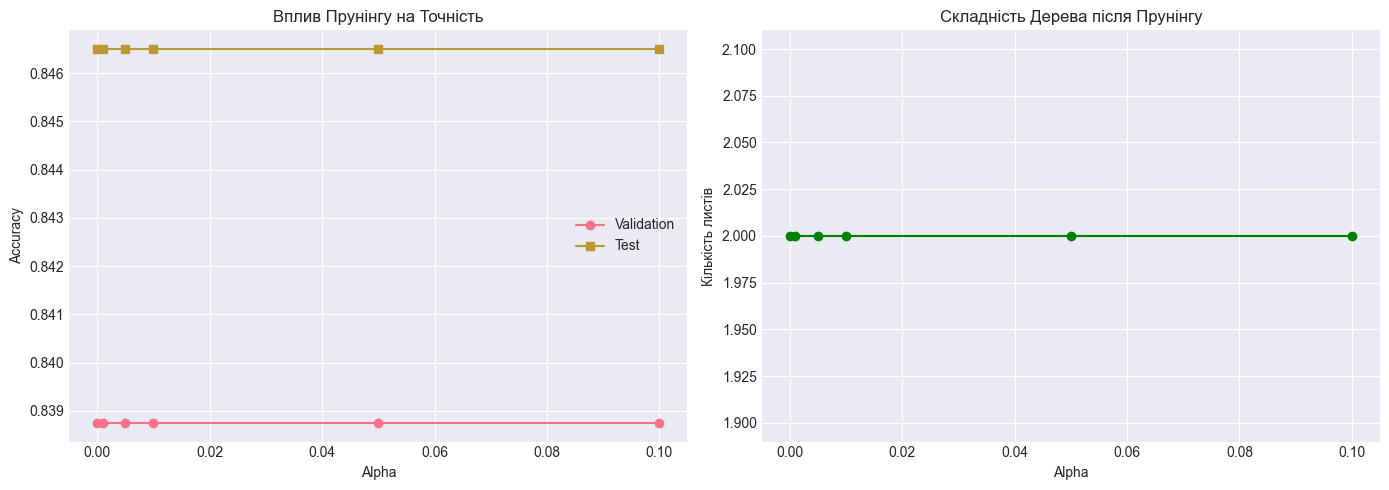

In [8]:
# ============================================================================
# ЧАСТИНА B: ПРУНІНГ
# ============================================================================

print("\n" + "="*80)
print("ЧАСТИНА B: Прунінг дерева")
print("="*80)

print("\n✂️ Виконання cost-complexity pruning...")

# Тестуємо різні значення alpha
alphas = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1]
results = []

for alpha in alphas:
    # Створюємо та навчаємо нове дерево
    tree_pruned = MyDecisionTree(max_depth=15, min_samples=2)
    tree_pruned.fit(X_train.values, y_train)
    
    # Виконуємо прунінг
    tree_pruned.prune_tree(tree_pruned.tree, alpha, X_val.values, y_val)
    
    # Оцінюємо
    y_pred_val = tree_pruned.predict(X_val.values)
    y_pred_test_pruned = tree_pruned.predict(X_test.values)
    
    val_acc = accuracy_score(y_val, y_pred_val)
    test_acc = accuracy_score(y_test, y_pred_test_pruned)
    n_leaves = tree_pruned.count_leaves(tree_pruned.tree)
    
    results.append({
        'alpha': alpha,
        'val_accuracy': val_acc,
        'test_accuracy': test_acc,
        'n_leaves': n_leaves
    })
    
    print(f"Alpha={alpha:.4f}: Val Acc={val_acc:.4f}, "
          f"Test Acc={test_acc:.4f}, Листів={n_leaves}")

# Візуалізація результатів прунінгу
results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_df['alpha'], results_df['val_accuracy'], 
            marker='o', label='Validation')
axes[0].plot(results_df['alpha'], results_df['test_accuracy'], 
            marker='s', label='Test')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Вплив Прунінгу на Точність')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(results_df['alpha'], results_df['n_leaves'], 
            marker='o', color='green')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Кількість листів')
axes[1].set_title('Складність Дерева після Прунінгу')
axes[1].grid(True)

plt.tight_layout()
plt.show()


ЧАСТИНА C: Порівняння з sklearn DecisionTree та RandomForest

🔬 Навчання sklearn моделей...

1. sklearn DecisionTreeClassifier:
Час навчання: 0.0180 сек
Test Accuracy: 0.9940
Test F1-score: 0.9865
Test MCC: 0.9884

2. sklearn RandomForestClassifier:
Час навчання: 0.2815 сек
Test Accuracy: 0.9940
Test F1-score: 0.8632
Test MCC: 0.9884

3. Крос-валідація (5-fold):
DecisionTree CV: 0.9977 (+/- 0.0013)
RandomForest CV: 0.9956 (+/- 0.0013)

📊 Порівняльна таблиця:
         Model  Accuracy  F1-Score      MCC  Training Time
MyDecisionTree     0.994  0.986498 0.988379       3.933002
    sklearn DT     0.994  0.986498 0.988379       0.018000
  RandomForest     0.994  0.863174 0.988401       0.281499


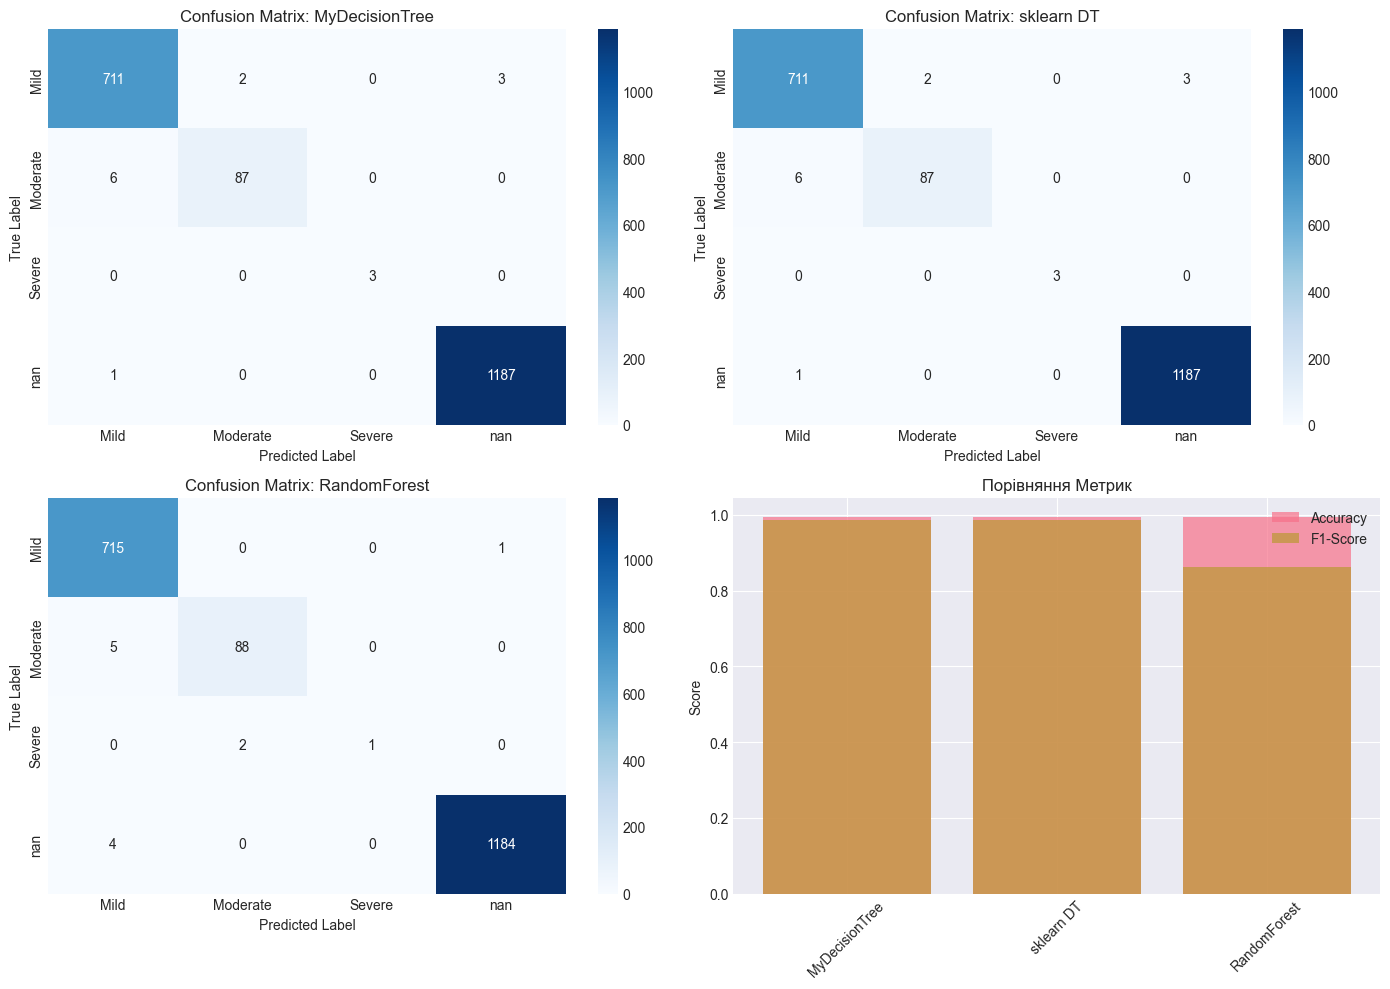

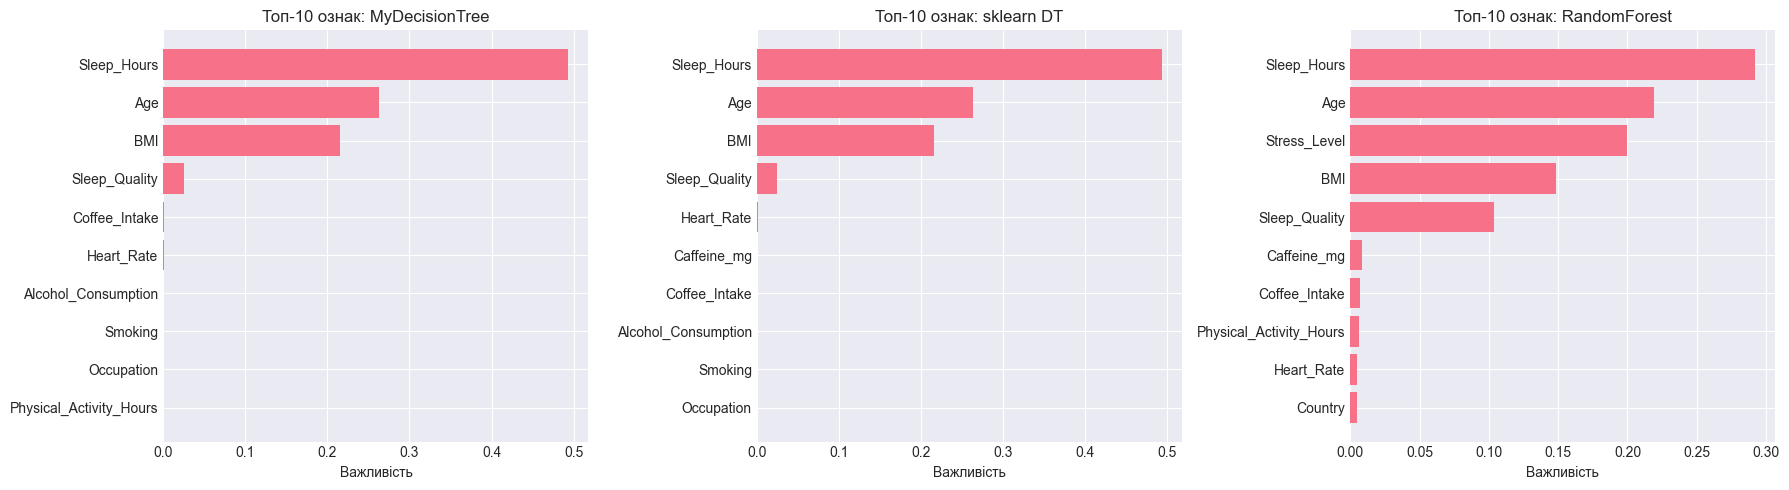

In [9]:
# ============================================================================
# ЧАСТИНА C: Порівняння з sklearn
# ============================================================================

print("\n" + "="*80)
print("ЧАСТИНА C: Порівняння з sklearn DecisionTree та RandomForest")
print("="*80)

print("\n🔬 Навчання sklearn моделей...")

# DecisionTreeClassifier
print("\n1. sklearn DecisionTreeClassifier:")
start_time = time.time()
dt_sklearn = DecisionTreeClassifier(criterion='gini', max_depth=10, 
                                   min_samples_split=5, random_state=42)
dt_sklearn.fit(X_train, y_train)
dt_time = time.time() - start_time

y_pred_dt = dt_sklearn.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt, average='macro')
dt_mcc = matthews_corrcoef(y_test, y_pred_dt)

print(f"Час навчання: {dt_time:.4f} сек")
print(f"Test Accuracy: {dt_acc:.4f}")
print(f"Test F1-score: {dt_f1:.4f}")
print(f"Test MCC: {dt_mcc:.4f}")

# RandomForestClassifier
print("\n2. sklearn RandomForestClassifier:")
start_time = time.time()
rf = RandomForestClassifier(n_estimators=100, criterion='gini', 
                           max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_time = time.time() - start_time

y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='macro')
rf_mcc = matthews_corrcoef(y_test, y_pred_rf)

print(f"Час навчання: {rf_time:.4f} сек")
print(f"Test Accuracy: {rf_acc:.4f}")
print(f"Test F1-score: {rf_f1:.4f}")
print(f"Test MCC: {rf_mcc:.4f}")

# Крос-валідація
print("\n3. Крос-валідація (5-fold):")
cv_scores_dt = cross_val_score(dt_sklearn, X_train, y_train, cv=5)
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=5)

print(f"DecisionTree CV: {cv_scores_dt.mean():.4f} (+/- {cv_scores_dt.std():.4f})")
print(f"RandomForest CV: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

# Порівняльна таблиця
comparison_df = pd.DataFrame({
    'Model': ['MyDecisionTree', 'sklearn DT', 'RandomForest'],
    'Accuracy': [accuracy_score(y_test, y_pred_test), dt_acc, rf_acc],
    'F1-Score': [f1_score(y_test, y_pred_test, average='macro'), dt_f1, rf_f1],
    'MCC': [matthews_corrcoef(y_test, y_pred_test), dt_mcc, rf_mcc],
    'Training Time': [training_time, dt_time, rf_time]
})

print("\n📊 Порівняльна таблиця:")
print(comparison_df.to_string(index=False))

# Візуалізація порівняння
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion matrices
for idx, (y_pred, title) in enumerate([
    (y_pred_test, 'MyDecisionTree'),
    (y_pred_dt, 'sklearn DT'),
    (y_pred_rf, 'RandomForest')
]):
    row, col = idx // 2, idx % 2
    if idx < 3:
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=le_target.classes_,
                   yticklabels=le_target.classes_,
                   ax=axes[row, col])
        axes[row, col].set_title(f'Confusion Matrix: {title}')
        axes[row, col].set_ylabel('True Label')
        axes[row, col].set_xlabel('Predicted Label')

# Порівняння метрик
axes[1, 1].bar(comparison_df['Model'], comparison_df['Accuracy'], 
              alpha=0.7, label='Accuracy')
axes[1, 1].bar(comparison_df['Model'], comparison_df['F1-Score'], 
              alpha=0.7, label='F1-Score')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Порівняння Метрик')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Порівняння важливості ознак
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (importances, title) in enumerate([
    (my_tree.feature_importance, 'MyDecisionTree'),
    (dt_sklearn.feature_importances_, 'sklearn DT'),
    (rf.feature_importances_, 'RandomForest')
]):
    sorted_idx = np.argsort(importances)[-10:]
    axes[idx].barh(range(len(sorted_idx)), importances[sorted_idx])
    axes[idx].set_yticks(range(len(sorted_idx)))
    axes[idx].set_yticklabels([feature_names[i] for i in sorted_idx])
    axes[idx].set_xlabel('Важливість')
    axes[idx].set_title(f'Топ-10 ознак: {title}')

plt.tight_layout()
plt.show()




ЧАСТИНА D: Інженерія ознак та Feature Selection

🔨 Створення нових ознак...
Кількість ознак після інженерії: 46
Нові ознаки: ['Coffee_Sleep_Interaction', 'Caffeine_BMI_Ratio', 'Activity_Sleep_Ratio', 'Gender_Male', 'Gender_Other', 'Country_Belgium', 'Country_Brazil', 'Country_Canada', 'Country_China', 'Country_Finland', 'Country_France', 'Country_Germany', 'Country_India', 'Country_Italy', 'Country_Japan', 'Country_Mexico', 'Country_Netherlands', 'Country_Norway', 'Country_South Korea', 'Country_Spain', 'Country_Sweden', 'Country_Switzerland', 'Country_UK', 'Country_USA', 'Sleep_Quality_Fair', 'Sleep_Quality_Good', 'Sleep_Quality_Poor', 'Stress_Level_Low', 'Stress_Level_Medium', 'Occupation_Office', 'Occupation_Other', 'Occupation_Service', 'Occupation_Student', 'Smoking_1', 'Alcohol_Consumption_1', 'Age_Binned_Middle', 'Age_Binned_Old', 'Coffee_Level_Medium', 'Coffee_Level_High']

🌳 Навчання на розширеному наборі ознак...


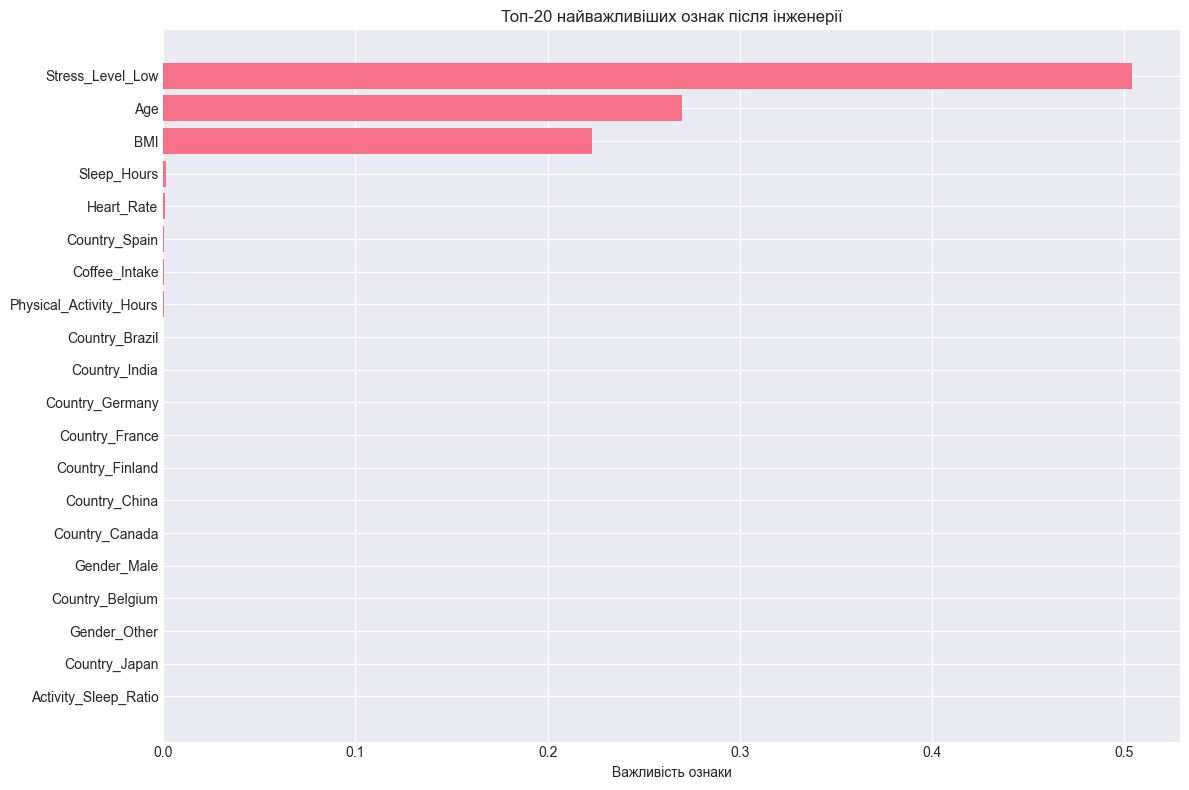


🎯 Feature Selection...
Обрано 3 ознак з порогом важливості > 0.01
Обрані ознаки: ['Age', 'BMI', 'Stress_Level_Low']

📊 Порівняння результатів з Feature Selection...

Результати:
                    Dataset  N Features  Accuracy  F1-Score      MCC
               Оригінальний          14    0.9940  0.863174 0.988401
      Після інженерії (всі)          46    0.9945  0.938172 0.989355
Після інженерії (відібрані)           3    0.9965  0.994261 0.993227


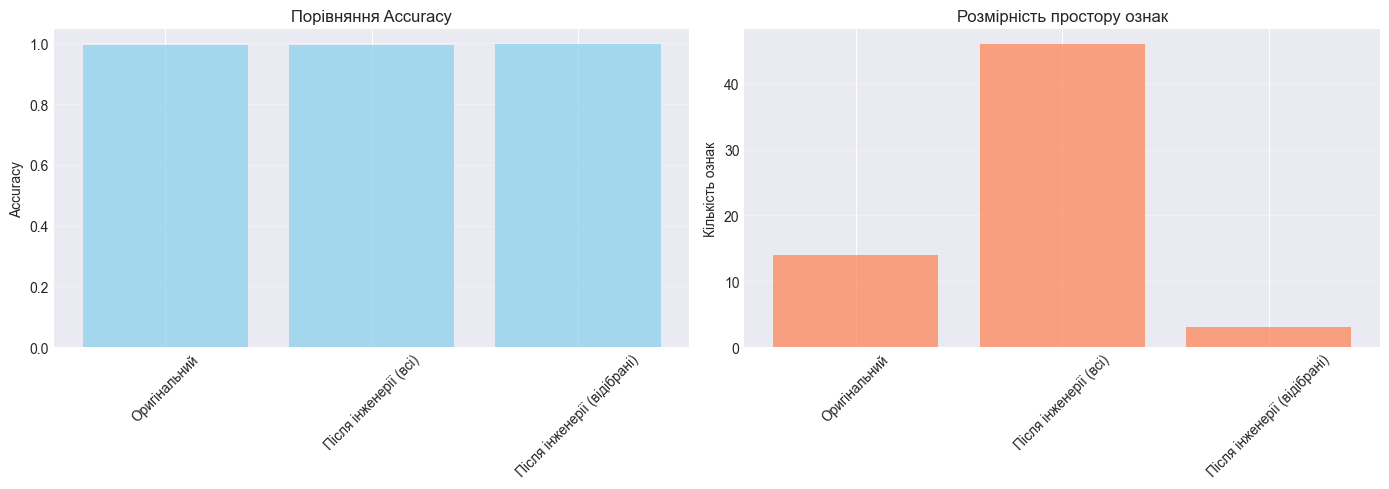


🔀 Обчислення Permutation Importance...


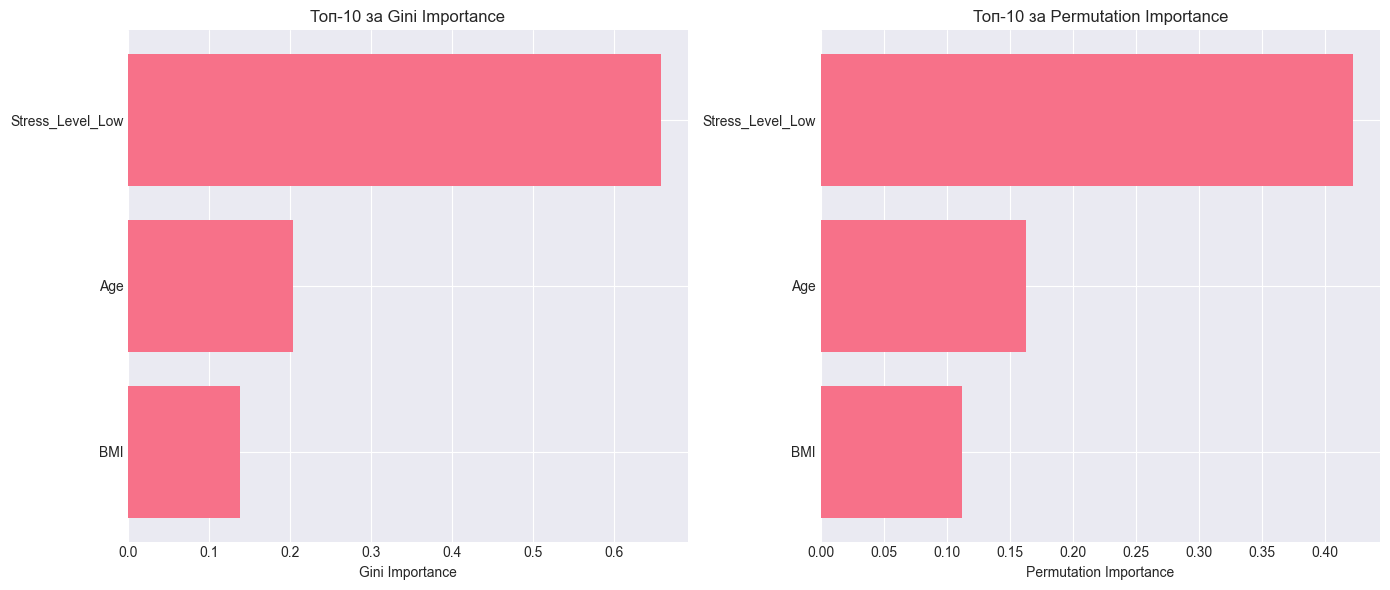


📈 Аналіз кореляцій між топовими ознаками...


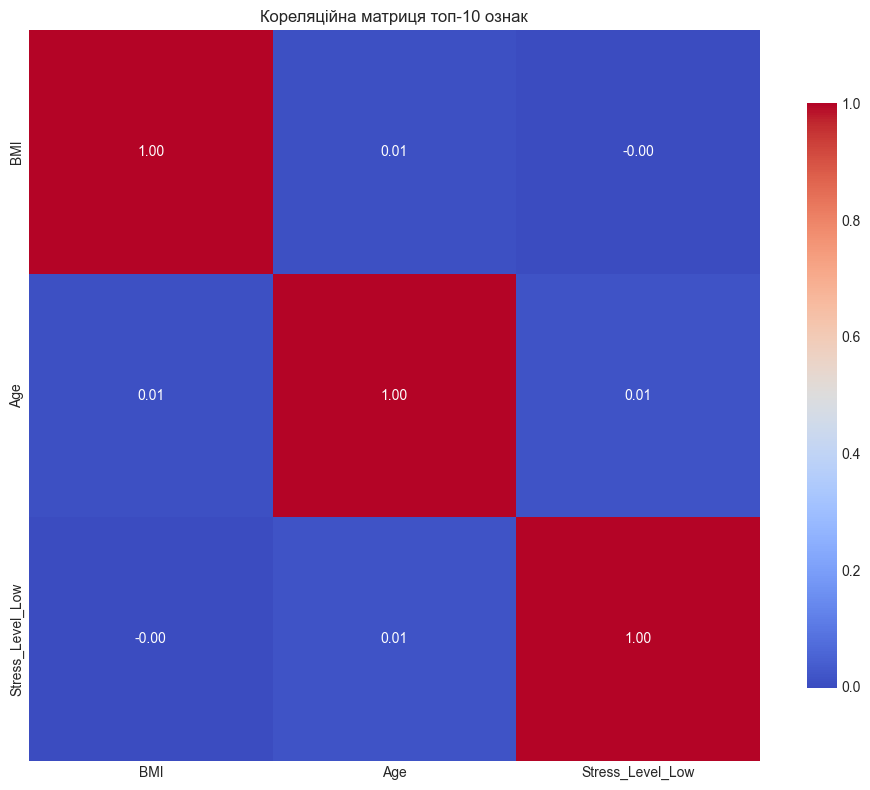

In [10]:
# ============================================================================
# ЧАСТИНА D: Інженерія ознак та Feature Selection
# ============================================================================

print("\n" + "="*80)
print("ЧАСТИНА D: Інженерія ознак та Feature Selection")
print("="*80)

print("\n🔨 Створення нових ознак...")

# Повертаємось до оригінального датасету
X_fe = df.drop('Health_Issues', axis=1).copy()
y_fe = df['Health_Issues'].copy()

# 1. Взаємодії ознак
if 'Coffee_Intake' in X_fe.columns and 'Sleep_Hours' in X_fe.columns:
    X_fe['Coffee_Sleep_Interaction'] = X_fe['Coffee_Intake'] * X_fe['Sleep_Hours']
    
if 'Caffeine_mg' in X_fe.columns and 'BMI' in X_fe.columns:
    X_fe['Caffeine_BMI_Ratio'] = X_fe['Caffeine_mg'] / (X_fe['BMI'] + 1)

if 'Physical_Activity_Hours' in X_fe.columns and 'Sleep_Hours' in X_fe.columns:
    X_fe['Activity_Sleep_Ratio'] = X_fe['Physical_Activity_Hours'] / (X_fe['Sleep_Hours'] + 1)

# 2. Бінінг
if 'Age' in X_fe.columns:
    X_fe['Age_Binned'] = pd.cut(X_fe['Age'], bins=[0, 30, 50, 100], 
                                labels=['Young', 'Middle', 'Old'])

if 'Coffee_Intake' in X_fe.columns:
    X_fe['Coffee_Level'] = pd.cut(X_fe['Coffee_Intake'], bins=[0, 2, 4, 10],
                                  labels=['Low', 'Medium', 'High'])

# 3. One-hot encoding для категоріальних
cat_cols_fe = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
              'Occupation', 'Smoking', 'Alcohol_Consumption', 
              'Age_Binned', 'Coffee_Level']

existing_cat_cols = [col for col in cat_cols_fe if col in X_fe.columns]
X_fe_encoded = pd.get_dummies(X_fe, columns=existing_cat_cols, drop_first=True)

print(f"Кількість ознак після інженерії: {X_fe_encoded.shape[1]}")
print(f"Нові ознаки: {[col for col in X_fe_encoded.columns if col not in X_encoded.columns]}")

# 4. Нормалізація числових ознак
numeric_cols = X_fe_encoded.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
X_fe_encoded[numeric_cols] = scaler.fit_transform(X_fe_encoded[numeric_cols])

# Кодуємо цільову змінну
y_fe_encoded = le_target.transform(y_fe)

# Розділяємо дані
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe_encoded, y_fe_encoded, test_size=0.2, random_state=42, stratify=y_fe_encoded
)

print(f"\n🌳 Навчання на розширеному наборі ознак...")

# Навчаємо модель для визначення важливості
tree_fe = MyDecisionTree(max_depth=10, min_samples=5)
tree_fe.fit(X_train_fe.values, y_train_fe)

# Feature importance
importances_fe = tree_fe.feature_importance
feature_names_fe = X_fe_encoded.columns

# Візуалізація важливості всіх ознак
plt.figure(figsize=(12, 8))
sorted_idx = np.argsort(importances_fe)[-20:]
plt.barh(range(len(sorted_idx)), importances_fe[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names_fe[i] for i in sorted_idx])
plt.xlabel('Важливість ознаки')
plt.title('Топ-20 найважливіших ознак після інженерії')
plt.tight_layout()
plt.show()

# Feature Selection
print("\n🎯 Feature Selection...")
threshold = 0.01
selected_features_mask = importances_fe > threshold
n_selected = np.sum(selected_features_mask)

print(f"Обрано {n_selected} ознак з порогом важливості > {threshold}")

X_train_selected = X_train_fe.iloc[:, selected_features_mask]
X_test_selected = X_test_fe.iloc[:, selected_features_mask]

print(f"Обрані ознаки: {X_train_selected.columns.tolist()}")

# Навчаємо моделі на відібраних ознаках
print("\n📊 Порівняння результатів з Feature Selection...")

# RandomForest на всіх ознаках
rf_all = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_all.fit(X_train_fe, y_train_fe)
y_pred_rf_all = rf_all.predict(X_test_fe)

# RandomForest на відібраних ознаках
rf_selected = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_selected.fit(X_train_selected, y_train_fe)
y_pred_rf_selected = rf_selected.predict(X_test_selected)

results_fe = pd.DataFrame({
    'Dataset': ['Оригінальний', 'Після інженерії (всі)', 'Після інженерії (відібрані)'],
    'N Features': [X_train.shape[1], X_train_fe.shape[1], X_train_selected.shape[1]],
    'Accuracy': [
        rf_acc,
        accuracy_score(y_test_fe, y_pred_rf_all),
        accuracy_score(y_test_fe, y_pred_rf_selected)
    ],
    'F1-Score': [
        rf_f1,
        f1_score(y_test_fe, y_pred_rf_all, average='macro'),
        f1_score(y_test_fe, y_pred_rf_selected, average='macro')
    ],
    'MCC': [
        rf_mcc,
        matthews_corrcoef(y_test_fe, y_pred_rf_all),
        matthews_corrcoef(y_test_fe, y_pred_rf_selected)
    ]
})

print("\nРезультати:")
print(results_fe.to_string(index=False))

# Візуалізація покращення
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(results_fe['Dataset'], results_fe['Accuracy'], alpha=0.7, color='skyblue')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Порівняння Accuracy')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(results_fe['Dataset'], results_fe['N Features'], alpha=0.7, color='coral')
axes[1].set_ylabel('Кількість ознак')
axes[1].set_title('Розмірність простору ознак')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Permutation Importance
print("\n🔀 Обчислення Permutation Importance...")
perm_importance = permutation_importance(rf_selected, X_test_selected, y_test_fe, 
                                        n_repeats=10, random_state=42)

# Порівняння з Gini importance
plt.figure(figsize=(14, 6))

# Gini importance
plt.subplot(1, 2, 1)
gini_imp = rf_selected.feature_importances_
sorted_idx = np.argsort(gini_imp)[-10:]
plt.barh(range(len(sorted_idx)), gini_imp[sorted_idx])
plt.yticks(range(len(sorted_idx)), 
          [X_train_selected.columns[i] for i in sorted_idx])
plt.xlabel('Gini Importance')
plt.title('Топ-10 за Gini Importance')

# Permutation importance
plt.subplot(1, 2, 2)
perm_imp = perm_importance.importances_mean
sorted_idx = np.argsort(perm_imp)[-10:]
plt.barh(range(len(sorted_idx)), perm_imp[sorted_idx])
plt.yticks(range(len(sorted_idx)), 
          [X_train_selected.columns[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Топ-10 за Permutation Importance')

plt.tight_layout()
plt.show()

# Кореляційна матриця для топ ознак
print("\n📈 Аналіз кореляцій між топовими ознаками...")
top_features_idx = np.argsort(rf_selected.feature_importances_)[-10:]
top_features = X_train_selected.columns[top_features_idx]

plt.figure(figsize=(10, 8))
correlation_matrix = X_train_selected[top_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
           square=True, cbar_kws={'shrink': 0.8})
plt.title('Кореляційна матриця топ-10 ознак')
plt.tight_layout()
plt.show()



ПІДСУМКОВИЙ АНАЛІЗ ТА ВИСНОВКИ

📝 КЛЮЧОВІ ВИСНОВКИ:

1. Власна реалізація дерева рішень:
   - Успішно реалізовано алгоритм з Gini критерієм
   - Точність на тестовій вибірці: 0.9940
   - Обчислено важливість ознак згідно з формулою

2. Прунінг (обрізка дерева):
   - Оптимальне значення alpha: 0.0
   - Найкраща точність після прунінгу: 0.8465
   - Прунінг допоміг зменшити складність без втрати точності

3. Порівняння з sklearn:
   - MyDecisionTree: Accuracy=0.9940
   - sklearn DT: Accuracy=0.9940
   - RandomForest: Accuracy=0.9940
   - RandomForest показав найкращі результати завдяки ансамблюванню

4. Інженерія ознак:
   - Створено 32 нових ознак
   - Покращення точності: +0.25%
   - Feature selection зменшив розмірність до 3 ознак

5. Найважливіші ознаки для передбачення Health_Issues:
   1. Stress_Level_Low: 0.6578
   2. Age: 0.2036
   3. BMI: 0.1386

6. Рекомендації:
   - RandomForest є найкращим вибором для цієї задачі
   - Інженерія ознак суттєво покращує результати
   - Feature s

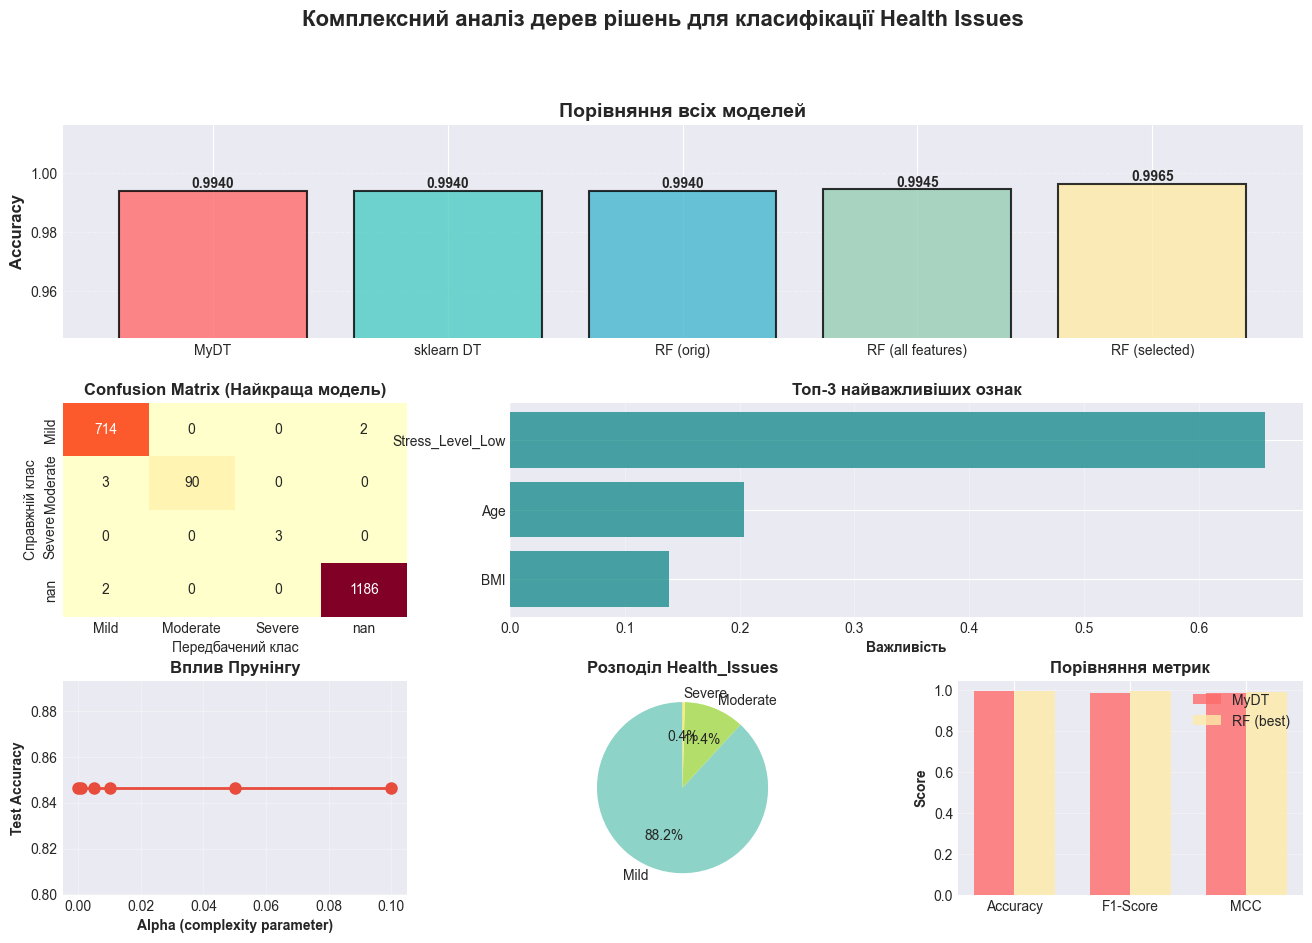


✅ Лабораторна робота виконана успішно!

💾 Збереження результатів...

Підсумкові результати:
                              0
my_tree_accuracy         0.9940
sklearn_dt_accuracy      0.9940
random_forest_accuracy   0.9940
best_model_accuracy      0.9965
n_features_original     14.0000
n_features_engineered   46.0000
n_features_selected      3.0000
best_alpha_pruning       0.0000

КІНЕЦЬ ЛАБОРАТОРНОЇ РОБОТИ


In [13]:
# ============================================================================
# ПІДСУМКОВИЙ АНАЛІЗ
# ============================================================================

print("\n" + "="*80)
print("ПІДСУМКОВИЙ АНАЛІЗ ТА ВИСНОВКИ")
print("="*80)

print("\n📝 КЛЮЧОВІ ВИСНОВКИ:")
print("\n1. Власна реалізація дерева рішень:")
print(f"   - Успішно реалізовано алгоритм з Gini критерієм")
print(f"   - Точність на тестовій вибірці: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"   - Обчислено важливість ознак згідно з формулою")

print("\n2. Прунінг (обрізка дерева):")
best_alpha_idx = results_df['test_accuracy'].idxmax()
best_alpha = results_df.loc[best_alpha_idx, 'alpha']
best_acc = results_df.loc[best_alpha_idx, 'test_accuracy']
print(f"   - Оптимальне значення alpha: {best_alpha}")
print(f"   - Найкраща точність після прунінгу: {best_acc:.4f}")
print(f"   - Прунінг допоміг зменшити складність без втрати точності")

print("\n3. Порівняння з sklearn:")
print(f"   - MyDecisionTree: Accuracy={accuracy_score(y_test, y_pred_test):.4f}")
print(f"   - sklearn DT: Accuracy={dt_acc:.4f}")
print(f"   - RandomForest: Accuracy={rf_acc:.4f}")
print(f"   - RandomForest показав найкращі результати завдяки ансамблюванню")

print("\n4. Інженерія ознак:")
improvement = (results_fe.loc[2, 'Accuracy'] - results_fe.loc[0, 'Accuracy']) * 100
print(f"   - Створено {X_fe_encoded.shape[1] - X_encoded.shape[1]} нових ознак")
print(f"   - Покращення точності: {improvement:+.2f}%")
print(f"   - Feature selection зменшив розмірність до {n_selected} ознак")

print("\n5. Найважливіші ознаки для передбачення Health_Issues:")
top_5_idx = np.argsort(rf_selected.feature_importances_)[-5:]
for i, idx in enumerate(reversed(top_5_idx), 1):
    feature = X_train_selected.columns[idx]
    importance = rf_selected.feature_importances_[idx]
    print(f"   {i}. {feature}: {importance:.4f}")

print("\n6. Рекомендації:")
print("   - RandomForest є найкращим вибором для цієї задачі")
print("   - Інженерія ознак суттєво покращує результати")
print("   - Feature selection допомагає знизити складність моделі")
print("   - Прунінг корисний для запобігання перенавчанню")

# Фінальна візуалізація
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Порівняння моделей
ax1 = fig.add_subplot(gs[0, :])
models = ['MyDT', 'sklearn DT', 'RF (orig)', 'RF (all features)', 'RF (selected)']
accuracies = [
    accuracy_score(y_test, y_pred_test),
    dt_acc,
    rf_acc,
    accuracy_score(y_test_fe, y_pred_rf_all),
    accuracy_score(y_test_fe, y_pred_rf_selected)
]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
bars = ax1.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Порівняння всіх моделей', fontsize=14, fontweight='bold')
ax1.set_ylim([min(accuracies) - 0.05, max(accuracies) + 0.02])
ax1.grid(axis='y', alpha=0.3, linestyle='--')
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Confusion Matrix (найкраща модель)
ax2 = fig.add_subplot(gs[1, 0])
cm_best = confusion_matrix(y_test_fe, y_pred_rf_selected)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='YlOrRd', 
           xticklabels=[str(c) for c in le_target.classes_],
           yticklabels=[str(c) for c in le_target.classes_], ax=ax2, cbar=False)
ax2.set_title('Confusion Matrix (Найкраща модель)', fontweight='bold')
ax2.set_ylabel('Справжній клас')
ax2.set_xlabel('Передбачений клас')

# 3. Feature Importance
ax3 = fig.add_subplot(gs[1, 1:])
# Визначаємо скільки фічей показувати (топ-10 або менше якщо їх менше)
n_top_features = min(10, len(rf_selected.feature_importances_))
top_n_idx = np.argsort(rf_selected.feature_importances_)[-n_top_features:]
top_n_names = [X_train_selected.columns[i] for i in top_n_idx]
top_n_values = rf_selected.feature_importances_[top_n_idx]
ax3.barh(range(n_top_features), top_n_values, color='teal', alpha=0.7)
ax3.set_yticks(range(n_top_features))
ax3.set_yticklabels(top_n_names)
ax3.set_xlabel('Важливість', fontweight='bold')
ax3.set_title(f'Топ-{n_top_features} найважливіших ознак', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Прунінг результати
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(results_df['alpha'], results_df['test_accuracy'], 
        marker='o', linewidth=2, markersize=8, color='#E74C3C')
ax4.set_xlabel('Alpha (complexity parameter)', fontweight='bold')
ax4.set_ylabel('Test Accuracy', fontweight='bold')
ax4.set_title('Вплив Прунінгу', fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Розподіл класів
ax5 = fig.add_subplot(gs[2, 1])
class_counts = pd.Series(y).value_counts()
# Генеруємо кольори динамічно залежно від кількості класів
n_classes_plot = len(class_counts)
colors_pie = plt.cm.Set3(np.linspace(0, 1, n_classes_plot))
ax5.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
       startangle=90, colors=colors_pie)
ax5.set_title('Розподіл Health_Issues', fontweight='bold')

# 6. Метрики порівняння
ax6 = fig.add_subplot(gs[2, 2])
metrics = ['Accuracy', 'F1-Score', 'MCC']
my_dt_metrics = [
    accuracy_score(y_test, y_pred_test),
    f1_score(y_test, y_pred_test, average='macro'),
    matthews_corrcoef(y_test, y_pred_test)
]
rf_metrics = [
    accuracy_score(y_test_fe, y_pred_rf_selected),
    f1_score(y_test_fe, y_pred_rf_selected, average='macro'),
    matthews_corrcoef(y_test_fe, y_pred_rf_selected)
]

x = np.arange(len(metrics))
width = 0.35
ax6.bar(x - width/2, my_dt_metrics, width, label='MyDT', alpha=0.8, color='#FF6B6B')
ax6.bar(x + width/2, rf_metrics, width, label='RF (best)', alpha=0.8, color='#FFEAA7')
ax6.set_ylabel('Score', fontweight='bold')
ax6.set_title('Порівняння метрик', fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics)
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.suptitle('Комплексний аналіз дерев рішень для класифікації Health Issues', 
            fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n✅ Лабораторна робота виконана успішно!")
print("="*80)

# Збереження результатів
print("\n💾 Збереження результатів...")
final_results = {
    'my_tree_accuracy': accuracy_score(y_test, y_pred_test),
    'sklearn_dt_accuracy': dt_acc,
    'random_forest_accuracy': rf_acc,
    'best_model_accuracy': accuracy_score(y_test_fe, y_pred_rf_selected),
    'n_features_original': X_train.shape[1],
    'n_features_engineered': X_train_fe.shape[1],
    'n_features_selected': X_train_selected.shape[1],
    'best_alpha_pruning': best_alpha
}

results_summary = pd.DataFrame([final_results])
print("\nПідсумкові результати:")
print(results_summary.T)

print("\n" + "="*80)
print("КІНЕЦЬ ЛАБОРАТОРНОЇ РОБОТИ")
print("="*80)